In [56]:
import os
import json
from web3 import Web3, HTTPProvider

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from utils.eth_blocks_utils import get_timestamp_for_block

In [30]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [31]:
pool_addr = "0x5a6A4D54456819380173272A5E8E9B9904BdF41B"

In [32]:
with open("./mim-3pool.json", 'r') as f:
    abi = json.load(f)
mim_3pool = web3.eth.contract(address=pool_addr, abi=abi)
mim_3pool

In [33]:
current_block = web3.eth.get_block_number()
current_block

13673437

In [34]:
genesis_block = 12557139

In [35]:
mim3pool_add_liquidity_filter = mim_3pool.events.AddLiquidity.createFilter(
    fromBlock=genesis_block,
    toBlock=current_block
)
mim3pool_remove_liquidity_filter = mim_3pool.events.RemoveLiquidity.createFilter(
    fromBlock=genesis_block,
    toBlock=current_block
)
mim3pool_remove_liquidity_one_filter = mim_3pool.events.RemoveLiquidityOne.createFilter(
    fromBlock=genesis_block,
    toBlock=current_block
)
mim3pool_remove_liquidity_imbalance_filter = mim_3pool.events.RemoveLiquidityImbalance.createFilter(
    fromBlock=genesis_block,
    toBlock=current_block
)


In [36]:
add_liquidity_events = mim3pool_add_liquidity_filter.get_all_entries()
add_liquidity_event_blocks = [event['blockNumber'] for event in add_liquidity_events]

In [37]:
remove_liquidity_events = (
        mim3pool_add_liquidity_filter.get_all_entries() +
        mim3pool_remove_liquidity_one_filter.get_all_entries() +
        mim3pool_remove_liquidity_imbalance_filter.get_all_entries()
)
remove_liquidity_event_blocks = [event['blockNumber'] for event in remove_liquidity_events]

In [40]:
len(remove_liquidity_event_blocks)

7949

In [43]:
block_steps = list(range(genesis_block, current_block, int(0.25 * round(current_block - genesis_block))))
block_ranges = list(zip(block_steps, block_steps[1:]))
block_ranges

[(12557139, 12836213),
 (12836213, 13115287),
 (13115287, 13394361),
 (13394361, 13673435)]

In [47]:
swap_event_blocks = []
for (block_start, block_end) in block_ranges:

    mim3pool_token_exchange_filter = mim_3pool.events.TokenExchange.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    mim3pool_token_exchange_underlying_filter = mim_3pool.events.TokenExchangeUnderlying.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    swap_events = (
            mim3pool_token_exchange_filter.get_all_entries() +
            mim3pool_token_exchange_underlying_filter.get_all_entries()
    )
    swap_event_blocks.extend([event['blockNumber'] for event in swap_events])

In [48]:
len(swap_event_blocks)

13217

In [55]:
remove_liquidity_events[0]

AttributeDict({'args': AttributeDict({'provider': '0xA79828DF1850E8a3A3064576f380D90aECDD3359',
  'token_amounts': [1000000000000000000, 982550782793487597],
  'fees': [0, 0],
  'invariant': 1999653412335332754,
  'token_supply': 1999653412335332754}),
 'event': 'AddLiquidity',
 'logIndex': 182,
 'transactionIndex': 98,
 'transactionHash': HexBytes('0x24dc3cee22548de65ac37891fd17e95e6842dc390e7e3672608af1e21c265fd2'),
 'address': '0x5a6A4D54456819380173272A5E8E9B9904BdF41B',
 'blockHash': HexBytes('0x3fab3b246b5e931f142a3de66987642e070b5464e6bf964a6796f21ebed92e8b'),
 'blockNumber': 12557271})

plots:

In [52]:
df_swap_event_blocks = pd.DataFrame(data=swap_event_blocks, columns=['block_number'])
df_swap_event_blocks['num_swaps'] = 1
df_swap_event_blocks['timestamp'] = [get_timestamp_for_block(block) for block in swap_event_blocks]
df_add_liquidity_blocks = pd.DataFrame(data=add_liquidity_event_blocks, columns=['block_number'])
df_add_liquidity_blocks['num_swaps'] = 1
df_remove_liquidity_blocks = pd.DataFrame(data=remove_liquidity_event_blocks, columns=['block_number'])
df_remove_liquidity_blocks['num_swaps'] = 1

In [81]:
bins = list(range(genesis_block, current_block, 50000))

In [103]:
def bin_txes(df, bins, column_name):
    df_binned = pd.cut(df['block_number'], bins=bins).value_counts()
    df_binned = df_binned.reset_index()
    df_binned['block_end'] = [a.right for a in df_binned['index']]
    df_binned.drop(columns=['index'], inplace=True)
    df_binned = df_binned.rename(columns={"block_number": column_name})
    df_binned.set_index("block_end", inplace=True)
    df_binned.sort_index(ascending=True, inplace=True)
    return df_binned

In [104]:
df_binned_swaps = bin_txes(df_swap_event_blocks, bins, 'num_swap_txes')
df_binned_add_liq = bin_txes(df_add_liquidity_blocks, bins, 'num_add_txes')
df_binned_remove_liq = bin_txes(df_remove_liquidity_blocks, bins, 'num_remove_txes')

In [106]:
df_all = pd.concat([df_binned_add_liq, df_binned_remove_liq, df_binned_swaps], axis=1)

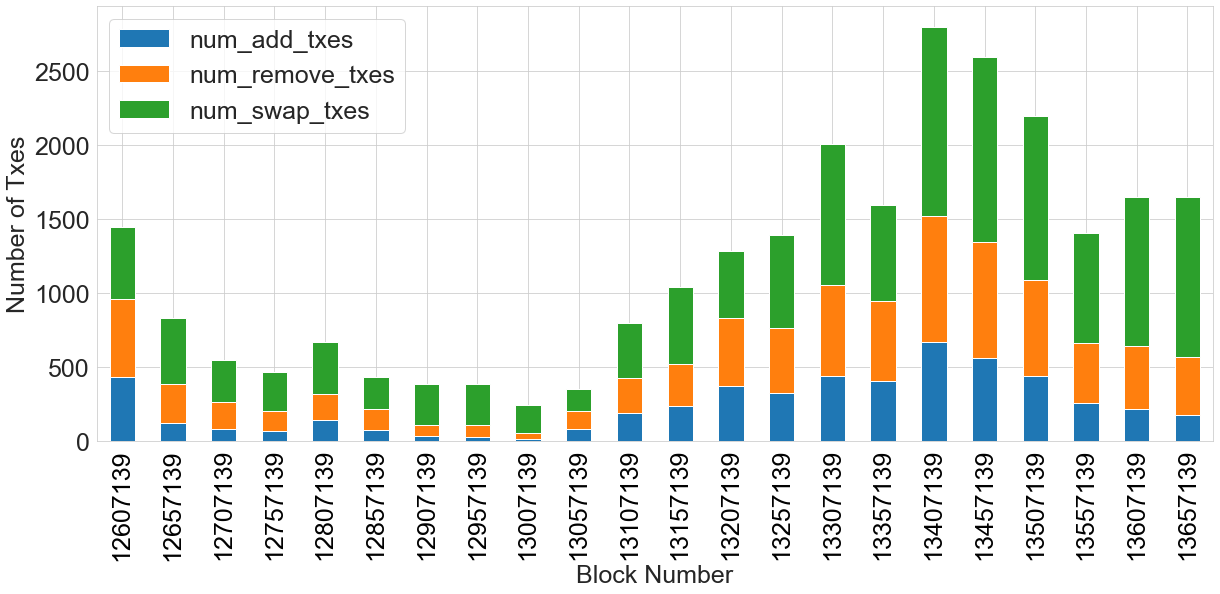

In [109]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

df_all.plot(
    ax=ax,
    kind='bar',
    stacked=True
)

ax.set_xlabel("Block Number", fontsize=25)
ax.set_ylabel("Number of Txes", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=25)